## Search the Best Arbitrage in Bostrom Pools

In [1]:
from subprocess import Popen, PIPE
import requests
import json
import pandas as pd
import numpy as np
from math import isnan
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

POOL_FEE = 0.0015
MIN_ARBITRAGE_REVENUE = 0.02
H_START_AMOUNT = 1_000_000
IBC_COIN_NAMES = \
    {
        'ibc/BA313C4A19DFBF943586C0387E6B11286F9E416B4DD27574E6909CABE0E342FA': 'uatom in bostrom',
        'ibc/13B2C536BB057AC79D5616B8EA1B9540EC1F2170718CAFF6F0083C966FFFED0B': 'uosmo in bostrom',
        'ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEADA9CA97EA622B25F41E5EB2': 'uatom in osmosis',
        'ibc/FE2CD1E6828EC0FAB8AF39BAC45BC25B965BA67CCBC50C13A14BD610B0D1E2C4': 'boot in osmosis'
     }
IBC_COIN_NAMES_INVERT = {v: k for k, v in IBC_COIN_NAMES.items()}
BOOT_RELATED_OSMO_POOLS = (1, 596, 597)
OSMO_POOLS_API_URL = 'https://lcd-osmosis.keplr.app/osmosis/gamm/v1beta1/pools?pagination.limit=750'

#### Get Pool Data from Bostrom

In [2]:
def execute_bash(bash_command: str):
    if len(bash_command.split('"')) == 1:
        _bash_command_list = bash_command.split()
    elif len(bash_command.split('"')) == 2:
        _bash_command_list = \
            bash_command.split('"')[0].split() + \
            [bash_command.split('"')[1]]
    elif len(bash_command.split('"')) > 2:
        _bash_command_list = \
            bash_command.split('"')[0].split() + \
            [bash_command.split('"')[1]] + \
            [item for items in bash_command.split('"')[2:] for item in items.split()]
    else:
        return None, f'Cannot split bash command {bash_command}'
    popen_process = Popen(_bash_command_list, stdout=PIPE)
    return popen_process.communicate(timeout=15)

def get_json_from_bash_query(bash_command: str):
    _res = execute_bash(bash_command)
    if _res[0]:
        return json.loads(_res[0].decode('utf8').replace("'", '"'))
    return

def rename_denom(denom: str) -> str:
    return IBC_COIN_NAMES[denom] if denom in IBC_COIN_NAMES.keys() else denom

pools_bostrom_json = get_json_from_bash_query('cyber query liquidity pools --node https://rpc.bostrom.cybernode.ai:443 -o json')
pools_bostrom_df = pd.DataFrame(pools_bostrom_json['pools'])
pools_bostrom_df['balances'] = \
    pools_bostrom_df['reserve_account_address'].map(
        lambda address: get_json_from_bash_query(f'cyber query bank balances {address} --node https://rpc.bostrom.cybernode.ai:443 -o json')['balances'])
pools_bostrom_df['balances'] = \
    pools_bostrom_df['balances'].map(lambda x: [{'denom': rename_denom(item['denom']), 'amount': item['amount']} for item in x])
pools_bostrom_df['reserve_coin_denoms'] = \
    pools_bostrom_df['reserve_coin_denoms'].map(lambda x: [rename_denom(item) for item in x])
pools_bostrom_df['swap_fee'] = 0.003
display(HTML(pools_bostrom_df.to_html(index=False, notebook=True, show_dimensions=False)))

id,type_id,reserve_coin_denoms,reserve_account_address,pool_coin_denom,balances,swap_fee
1,1,"[boot, hydrogen]",bostrom1wrtkzr96362ty7ad0qrwhkpx743xcjrtv7j2cw,pool70D7610CBA8E94B27BAD7806EBD826F5626C486BBF5...,"[{'denom': 'boot', 'amount': '72151821321'}, {'...",0.003
2,1,"[boot, milliampere]",bostrom1y7au5el59mf8mlak53gfvmr75gr2m2jz6lra0s,pool27BBCA67F42ED27DFFB6A450966C7EA206ADAA42BA0...,"[{'denom': 'boot', 'amount': '18676551180'}, {'...",0.003
3,1,"[boot, tocyb]",bostrom1tkpsxklqu74eqsmezcwnc5hmfswrjgn9elcneq,pool5D83035BE0E7AB904379161D3C52FB4C1C392265AC1...,"[{'denom': 'boot', 'amount': '11014915804'}, {'...",0.003
4,1,"[hydrogen, tocyb]",bostrom1kqkwg2eq9fc5r8f0n66fj6ekc5h3kkmqhthkqx,poolB02CE42B202A71419D2F9EB4996B36C52F1B5B60DAF...,"[{'denom': 'hydrogen', 'amount': '25578916468'}...",0.003
5,1,"[hydrogen, milliampere]",bostrom10xu73c3nkcdcf6j6u4j2kzq0cjftfj2nv7xz9y,pool79B9E8E233B61B84EA5AE564AB080FC492B4C953A9D...,"[{'denom': 'hydrogen', 'amount': '468169413575'...",0.003
6,1,"[hydrogen, millivolt]",bostrom1u3u628ue3c5hn7ya4x4cjlk5t2d0unnarrq34k,poolE479A51F998E2979F89DA9AB897ED45A9AFE4E7DE32...,"[{'denom': 'hydrogen', 'amount': '498587400919'...",0.003
7,1,"[hydrogen, uosmo in bostrom]",bostrom1np5jg5xq8x7axptrgad8dxd8spg8tavjh5vnaz,pool98692450C039BDD30563475A7699A7805075F592A36...,"[{'denom': 'hydrogen', 'amount': '18914868766'}...",0.003
8,1,"[hydrogen, uatom in bostrom]",bostrom1mgv368468aq8fsk2kynh0lpcsgtwa53zzlnhp0,poolDA191D1EBA3F4074C2CAB12777FC388216EED222F57...,"[{'denom': 'hydrogen', 'amount': '34209998028'}...",0.003
9,1,"[uosmo in bostrom, uatom in bostrom]",bostrom1tyx5u9mgwxzzj6rstsjxmfswpft75s0euh5ppu,pool590D4E176871842968705C246DA60E0A57EA41F9257...,"[{'denom': 'uosmo in bostrom', 'amount': '49612...",0.003


#### Get Pool Data from Osmosis

In [3]:
pools_osmosis_json = requests.get(OSMO_POOLS_API_URL).json()['pools']
pools_osmosis_df = pd.DataFrame([item for item in pools_osmosis_json])
pools_osmosis_df['id'] = pools_osmosis_df['id'].astype(int)
pools_osmosis_df['totalWeight'] = pools_osmosis_df['totalWeight'].astype(int)
pools_osmosis_df['balances'] = pools_osmosis_df['poolAssets'].map(lambda x: [item['token'] for item in x])
pools_osmosis_df['balances'] = \
    pools_osmosis_df['balances'].map(lambda x: [{'denom': rename_denom(item['denom']), 'amount': item['amount']} for item in x])
pools_osmosis_df['denoms_count'] = pools_osmosis_df['poolAssets'].map(lambda x: len(x))
pools_osmosis_df['swap_fee'] = pools_osmosis_df['poolParams'].map(lambda x: float(x['swapFee']))
pools_osmosis_df['reserve_coin_denoms'] = pools_osmosis_df['poolAssets'].map(lambda x: [item['token']['denom'] for item in x])
pools_osmosis_df['reserve_coin_denoms'] = \
    pools_osmosis_df['reserve_coin_denoms'].map(lambda x: [rename_denom(item) for item in x])
display(HTML(
    pools_osmosis_df[pools_osmosis_df.id.isin(BOOT_RELATED_OSMO_POOLS)]
        .sort_values('totalWeight', ascending=False).to_html(index=False, notebook=True, show_dimensions=False)))

@type,address,id,poolParams,future_pool_governor,totalShares,poolAssets,totalWeight,balances,denoms_count,swap_fee,reserve_coin_denoms
/osmosis.gamm.v1beta1.Pool,osmo1mw0ac6rwlp5r8wapwk3zs6g29h8fcscxqakdzw9emk...,1,"{'swapFee': '0.003000000000000000', 'exitFee': ...",24h,"{'denom': 'gamm/pool/1', 'amount': '34418621186...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,"[{'denom': 'uatom in osmosis', 'amount': '65603...",2,0.003,"[uatom in osmosis, uosmo]"
/osmosis.gamm.v1beta1.Pool,osmo1jtzkz2383cegga8pzq7azm7tp3lcutep95urpvuqxz...,596,"{'swapFee': '0.003000000000000000', 'exitFee': ...",24h,"{'denom': 'gamm/pool/596', 'amount': '113365631...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,"[{'denom': 'uatom in osmosis', 'amount': '76620...",2,0.003,"[uatom in osmosis, boot in osmosis]"
/osmosis.gamm.v1beta1.Pool,osmo19zg3tz4q5t3x6d2hdmwfkud4d3l3x8r4szr6clvlss...,597,"{'swapFee': '0.002000000000000000', 'exitFee': ...",24h,"{'denom': 'gamm/pool/597', 'amount': '117865174...",[{'token': {'denom': 'ibc/FE2CD1E6828EC0FAB8AF3...,1073741824000000,"[{'denom': 'boot in osmosis', 'amount': '852569...",2,0.002,"[boot in osmosis, uosmo]"


#### Bostrom and Osmosis pools

In [4]:
pools_bostrom_df['network'] = 'bostrom'
pools_osmosis_df['network'] = 'osmosis'
pools_df = pools_bostrom_df[['network', 'id', 'balances', 'reserve_coin_denoms', 'swap_fee']].append(
    pools_osmosis_df[(pools_osmosis_df.denoms_count == 2) &
                     (pools_osmosis_df.id.isin(BOOT_RELATED_OSMO_POOLS))]
    [['network', 'id', 'balances', 'swap_fee', 'reserve_coin_denoms']])
display(HTML(
    pools_df.to_html(index=False, notebook=True, show_dimensions=False)))

network,id,balances,reserve_coin_denoms,swap_fee
bostrom,1,"[{'denom': 'boot', 'amount': '72151821321'}, {'...","[boot, hydrogen]",0.003
bostrom,2,"[{'denom': 'boot', 'amount': '18676551180'}, {'...","[boot, milliampere]",0.003
bostrom,3,"[{'denom': 'boot', 'amount': '11014915804'}, {'...","[boot, tocyb]",0.003
bostrom,4,"[{'denom': 'hydrogen', 'amount': '25578916468'}...","[hydrogen, tocyb]",0.003
bostrom,5,"[{'denom': 'hydrogen', 'amount': '468169413575'...","[hydrogen, milliampere]",0.003
bostrom,6,"[{'denom': 'hydrogen', 'amount': '498587400919'...","[hydrogen, millivolt]",0.003
bostrom,7,"[{'denom': 'hydrogen', 'amount': '18914868766'}...","[hydrogen, uosmo in bostrom]",0.003
bostrom,8,"[{'denom': 'hydrogen', 'amount': '34209998028'}...","[hydrogen, uatom in bostrom]",0.003
bostrom,9,"[{'denom': 'uosmo in bostrom', 'amount': '49612...","[uosmo in bostrom, uatom in bostrom]",0.003
osmosis,1,"[{'denom': 'uatom in osmosis', 'amount': '65603...","[uatom in osmosis, uosmo]",0.003


#### Calculate Prices

In [5]:
coins_list = list(pools_df['reserve_coin_denoms'])
coins_unique_set = set(np.concatenate(coins_list).flat)
price_df = pd.DataFrame(columns=coins_unique_set, index=coins_unique_set)

for index, pool_row in pools_df.iterrows():
    coins_pair = pool_row.reserve_coin_denoms
    balances = {item['denom']: int(item['amount']) for item in pool_row.balances}
    price_df.loc[coins_pair[0], coins_pair[1]] = balances[coins_pair[0]]/balances[coins_pair[1]] * (1 - POOL_FEE)
    price_df.loc[coins_pair[1], coins_pair[0]] = balances[coins_pair[1]]/balances[coins_pair[0]] * (1 - POOL_FEE)
for coin in coins_unique_set:
    price_df.loc[coin, coin] = 1
# price_df.rename(columns=IBC_COIN_NAMES, index=IBC_COIN_NAMES, inplace=True)

price_df.loc['uatom in bostrom', 'uatom in osmosis'] = 1
price_df.loc['uatom in osmosis', 'uatom in bostrom'] = 1
price_df.loc['uosmo', 'uosmo in bostrom'] = 1
price_df.loc['uosmo in bostrom', 'uosmo'] = 1
price_df.loc['boot', 'boot in osmosis'] = 1
price_df.loc['boot in osmosis', 'boot'] = 1


coins_unique_set = set(price_df.columns)
display(HTML(price_df.to_html(notebook=True, show_dimensions=False)))

,boot in osmosis,uatom in bostrom,uosmo,tocyb,milliampere,uosmo in bostrom,millivolt,boot,uatom in osmosis,hydrogen
boot in osmosis,1,NaN,23.946391,NaN,NaN,NaN,NaN,1,90.558656,NaN
uatom in bostrom,NaN,1,NaN,NaN,NaN,0.223761,NaN,NaN,1,0.005001
uosmo,0.041635,NaN,1,NaN,NaN,1,NaN,NaN,3.783244,NaN
tocyb,NaN,NaN,NaN,1,NaN,NaN,NaN,0.839335,NaN,0.460132
milliampere,NaN,NaN,NaN,NaN,1,NaN,NaN,0.000096,NaN,0.000052
uosmo in bostrom,NaN,4.45566,1,NaN,NaN,1,NaN,NaN,NaN,0.022573
millivolt,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0.000008
boot,1,NaN,NaN,1.187848,10333.96359,NaN,NaN,1,NaN,0.544197
uatom in osmosis,0.011009,1,0.263531,NaN,NaN,NaN,NaN,NaN,1,NaN
hydrogen,NaN,199.37609,NaN,2.166774,18992.389244,44.167734,130601.685414,1.83206,NaN,1


#### Prices without reference to network

In [6]:
price_enriched_df = price_df.copy()
for col in [['boot', 'boot in osmosis'], ['uosmo', 'uosmo in bostrom'], ['uatom in osmosis', 'uatom in bostrom']]:
    for index in price_df.index:
        if isnan(price_enriched_df.loc[index, col[0]]):
            price_enriched_df.loc[index, col[0]] = price_enriched_df.loc[index, col[1]]
            price_enriched_df.loc[col[0], index] = price_enriched_df.loc[col[1], index]
        elif isnan(price_enriched_df.loc[index, col[1]]):
            price_enriched_df.loc[index, col[1]] = price_enriched_df.loc[index, col[0]]
            price_enriched_df.loc[col[1], index] = price_enriched_df.loc[col[0], index]
price_enriched_df.drop(columns=['uatom in bostrom', 'uosmo in bostrom', 'boot in osmosis'],
                       index=['uatom in bostrom', 'uosmo in bostrom', 'boot in osmosis'])\
                .rename(columns={'uatom in osmosis': 'uatom'},
                        index={'uatom in osmosis': 'uatom'})

,uosmo,tocyb,milliampere,millivolt,boot,uatom,hydrogen
uosmo,1,NaN,NaN,NaN,0.041635,3.783244,0.022573
tocyb,NaN,1,NaN,NaN,0.839335,NaN,0.460132
milliampere,NaN,NaN,1,NaN,0.000096,NaN,0.000052
millivolt,NaN,NaN,NaN,1,NaN,NaN,0.000008
boot,23.946391,1.187848,10333.96359,NaN,1,90.558656,0.544197
uatom,0.263531,NaN,NaN,NaN,0.011009,1,0.005001
hydrogen,44.167734,2.166774,18992.389244,130601.685414,1.83206,199.37609,1


#### Pools Liquidity in GBOOT

In [7]:
def get_pool_liquidity(balances: list, target_denom: str = 'boot', main_liquidity_denom: str = 'hydrogen', price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']:int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return

network,id,reserve_coin_denoms,"liquidity, GBOOT"
bostrom,1,"[boot, hydrogen]",144.3
bostrom,2,"[boot, milliampere]",37.4
bostrom,3,"[boot, tocyb]",22.0
bostrom,4,"[hydrogen, tocyb]",27.8
bostrom,5,"[hydrogen, milliampere]",509.6
bostrom,6,"[hydrogen, millivolt]",542.7
bostrom,7,"[hydrogen, uosmo in bostrom]",20.6
bostrom,8,"[hydrogen, uatom in bostrom]",37.2
bostrom,9,"[uosmo in bostrom, uatom in bostrom]",23.8
osmosis,1,"[uatom in osmosis, uosmo]","1,188,192.0"


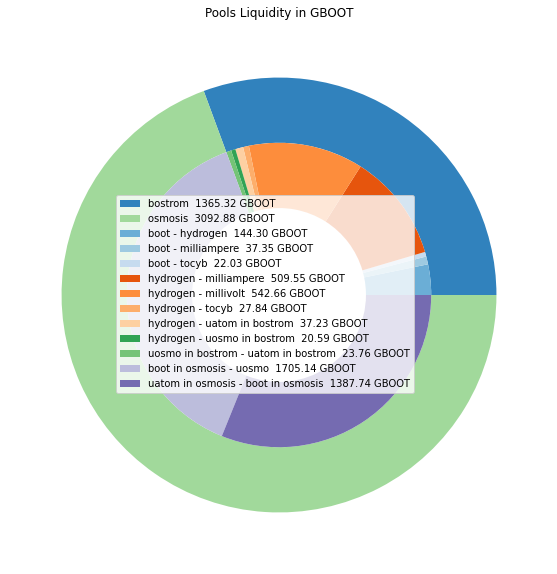

In [8]:
pools_df['liquidity, GBOOT'] = pools_df['balances'].map(get_pool_liquidity)/1e9
display(HTML(pools_df[['network', 'id', 'reserve_coin_denoms', 'liquidity, GBOOT']]
             .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
             .replace('text-align: left;', 'text-align: right')
             .replace('<tr>', '<tr align="right">')))

fig, ax = plt.subplots(figsize=(10,10))
size = 0.3
cm = plt.get_cmap("tab20c")
cout = cm(np.arange(2)*10)

pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df[pools_df.denoms != 'uatom in osmosis - uosmo'].groupby('network')['liquidity, GBOOT'].sum()
inner = pools_df[pools_df.denoms != 'uatom in osmosis - uosmo'].groupby(['network', 'denoms'])['liquidity, GBOOT'].sum()
inner_labels = ['{1}  {2:1.2f} GBOOT'.format(i[0], i[1],j) for i,j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:1.2f} GBOOT'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([1,2,3,4,5,6,7,8,9,14,12,13]))
ax.pie(inner.values.flatten(), radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set(aspect="equal", title='Pools Liquidity in GBOOT')

plt.legend(outer_labels + inner_labels, loc=(0.2, 0.32))
handles, labels = ax.get_legend_handles_labels()
plt.show()

#### Search the Best Arbitrage

In [9]:
result_list = []
for coin_1 in coins_unique_set:
    coin_1_amount = H_START_AMOUNT * price_df.loc[coin_1, 'hydrogen']
    if coin_1_amount > 0:
        for coin_2 in coins_unique_set.difference({coin_1}):
            coin_2_amount = coin_1_amount * price_df.loc[coin_2, coin_1]
            if coin_2_amount > 0:
                for coin_3 in coins_unique_set.difference({coin_1, coin_2}):
                    coin_3_amount = coin_2_amount * price_df.loc[coin_3, coin_2]
                    result = coin_3_amount * price_df.loc[coin_1, coin_3]
                    if result > coin_1_amount * (1 + MIN_ARBITRAGE_REVENUE):
                        result_list.append(
                                [[coin_1, coin_2, coin_3],
                                 round(result/coin_1_amount, 3)])
                    if coin_2_amount > 0:
                        for coin_4 in coins_unique_set.difference({coin_1, coin_2, coin_3}):
                            coin_4_amount = coin_3_amount * price_df.loc[coin_4, coin_3]
                            result = coin_4_amount * price_df.loc[coin_1, coin_4]
                            if result > coin_1_amount * (1 + MIN_ARBITRAGE_REVENUE):
                                result_list.append(
                                    [[coin_1, coin_2, coin_3, coin_4],
                                     round(result/coin_1_amount, 3)])

result_df =\
    pd.DataFrame(
        data=[[' -> '.join(coin for coin in item[0] + [item[0][0]]), item[1]] for item in result_list],
        columns=['arbitrage', 'revenue']).sort_values('revenue', ascending=False)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{0:7,.2f}'.format
display(HTML(result_df.to_html(index=False, notebook=True, show_dimensions=False)))


arbitrage,revenue
uatom in bostrom -> uosmo in bostrom -> uosmo -> uatom in osmosis -> uatom in bostrom,1.17
uosmo in bostrom -> uosmo -> uatom in osmosis -> uatom in bostrom -> uosmo in bostrom,1.17
